# Analysis of Statistician Mistakes in Reporting Football Events

## DAIP Case 4 (Group 6)

### Introduction

In the fast-paced world of football, statisticians play a critical role in accurately reporting match events such as yellow cards and corners. However, errors in reporting these events can compromise data integrity, affecting decision-making by coaches, analysts, and stakeholders. Our analysis focuses on understanding why moderate event errors (specifically yellow cards and corners) have increased since 2022, as observed in English and Scottish football leagues.

The problem is clear: the current rate of moderate event errors exceeds the target threshold of less than 2%. These errors can occur due to delays (over 3 seconds), mixed teams, confirmed/cancelled events, or missed events. The following statistics highlight the issue:

- **Scotland**:
  - 2022: 896 games, moderate mistakes @ 2.79% (25 mistakes)
  - 2023: 1248 games, moderate mistakes @ 3.93% (49 mistakes)
  - 2024: 1240 games, moderate mistakes @ 3.55% (44 mistakes)
- **England**:
  - 2022: 4393 games, moderate mistakes @ 3.39% (149 mistakes)
  - 2023: 4843 games, moderate mistakes @ 2.97% (144 mistakes)
  - 2024: 5274 games, moderate mistakes @ 3.34% (176 mistakes)

The key question we aim to answer is: **Why are there more events that statisticians have to report on, and is there a chance of making an error also increasing? And why are there more events?** Potential contributing factors include officiating changes, player behavior, and attacking styles, which may lead to more yellow cards and corners.

To address this, we conduct a comprehensive analysis of Statistician Network reporting data with statistics from English and Scottish football surrounding yellow cards and corners. This notebook presents our findings through detailed data analysis and visualizations, focusing on match volume, event density, match complexity, and regional differences.



### Notebook Structure

1. **Setup and Data Preprocessing**: Load and preprocess the datasets.
2. **Mistakes and Matches Volume Analysis**: Examine the increase in mistakes volume and its impact.
3. **Event Density Analysis**: Analyze trends in yellow cards, corners, and fouls over the years.
4. **Match Complexity Analysis**: Investigate how match intensity contributes to errors.
5. **Regional Differences**: Compare England and Scotland in terms of match intensity and mistake volume.
6. **Mistake Type Analysis**: Explore the distribution and trends of mistake types.
7. **Conclusion and Recommendations**: Summarize findings and propose solutions.


In [42]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind

# Set plot style for professional appearance
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['legend.title_fontsize'] = 12


## 1. Data Preprocessing

We load and preprocess two datasets:
1. **Corners and Yellow Cards Dataset**: Contains total corners and yellow cards per competition and year.
2. **Moderate Mistakes Dataset**: Details individual match events with moderate mistakes in reporting yellow cards and corners.

The preprocessing steps include converting columns to numeric types, extracting years, and calculating total actions per match.


In [43]:
# Function to load and preprocess a dataset
def load_and_preprocess_data(file_path, date_column=None, year_column=None, year_split=False):
    try:
        df = pd.read_excel(file_path)
        print(f"First 5 rows of the dataset '{file_path}':")
        print(df.head())
        print(f"\nColumn names in the dataset '{file_path}':")
        print(list(df.columns))

        if date_column:
            df['StartDate'] = pd.to_datetime(df[date_column])
            df['Year'] = df['StartDate'].dt.year
        elif year_column and year_split:
            df['Year'] = df[year_column].apply(lambda x: int(x.split('/')[1]))
        elif year_column:
            df['Year'] = df[year_column]

        return df
    except Exception as e:
        print(f"Error loading dataset '{file_path}': {e}")
        raise

# Function to convert columns to numeric
def convert_to_numeric(df, columns):
    available_cols = []
    for col in columns:
        matching_col = next((c for c in df.columns if c.lower() == col.lower()), None)
        if matching_col:
            available_cols.append(matching_col)
            df[matching_col] = pd.to_numeric(df[matching_col], errors='coerce')
        else:
            print(f"Column '{col}' not found in the dataset.")
    return df, available_cols

# Load datasets
df_corners_yc = load_and_preprocess_data('corners and yellow cards.xlsx', year_column='year', year_split=True)
df = load_and_preprocess_data('GS Eng.Sco. Moderate mistakes 22-24.xlsx', date_column='StartDate')

# Convert corner and yellow_card to numeric
df_corners_yc, _ = convert_to_numeric(df_corners_yc, ['corner', 'yellow card'])
df_corners_yc[['corner', 'yellow card']] = df_corners_yc[['corner', 'yellow card']].fillna(0)

# Define expected numeric columns for the mistakes dataset
numeric_cols = ['Goals', 'YC', 'RC', 'Penalties', 'Corners', 'foul ']
df, available_numeric_cols = convert_to_numeric(df, numeric_cols)
if available_numeric_cols:
    df[available_numeric_cols] = df[available_numeric_cols].fillna(0)
    print(f"\nFilled missing values in numeric columns: {available_numeric_cols}")
    df['TotalActions'] = df[available_numeric_cols].sum(axis=1)


First 5 rows of the dataset 'corners and yellow cards.xlsx':
        year                          Competition  corner  yellow card
0  2021/2022  England Premier League 2 Division 2  1801.0        670.0
1  2021/2022                 Scotland Premiership  2450.0        971.0
2  2021/2022                 England Championship  5420.0       2166.0
3  2021/2022                   England League Two  5438.0       2031.0
4  2021/2022                     England League 1  5654.0       2044.0

Column names in the dataset 'corners and yellow cards.xlsx':
['year', 'Competition', 'corner', 'yellow card']
First 5 rows of the dataset 'GS Eng.Sco. Moderate mistakes 22-24.xlsx':
   StartDate     Sport                                    Competition  \
0 2022-01-21  Football  2021/2022 England Premier League 2 Division 2   
1 2022-01-30  Football                 2021/2022 England Championship   
2 2022-02-05  Football                   2021/2022 England League Two   
3 2022-02-05  Football                

## 2. Mistakes and Matches Volume Analysis

We first examine the increase in the total number of mistakes from 2022 to 2024, as a higher volume of mistakes indicates increased challenges for statisticians in maintaining accuracy.

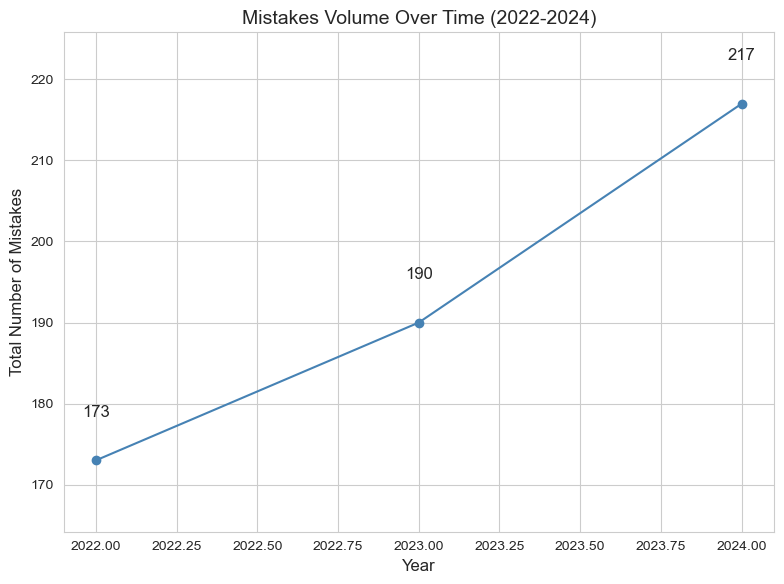

Mistakes Volume Increase (2022-2024): 25.4%


In [44]:
# Calculate total mistakes per year
mistakes_per_year = df.groupby('Year')['MistakeType'].count()

# Ensure the index (Year) is integer for consistency
mistakes_per_year.index = mistakes_per_year.index.astype(int)

# Plot mistakes volume over time
plt.figure(figsize=(8, 6))
mistakes_per_year.plot(kind='line', marker='o', color='steelblue')
plt.title('Mistakes Volume Over Time (2022-2024)')
plt.xlabel('Year')
plt.ylabel('Total Number of Mistakes')
plt.grid(True)
for x, y in zip(mistakes_per_year.index, mistakes_per_year):
    plt.text(x, y + 5, f'{int(y)}', ha='center', va='bottom')
plt.margins(y=0.2)    
plt.tight_layout()
plt.savefig('mistakes_volume_over_time.png')
plt.show()

# Calculate mistakes volume increase
mistakes_increase = ((mistakes_per_year[2024] - mistakes_per_year[2022]) / mistakes_per_year[2022]) * 100
print(f"Mistakes Volume Increase (2022-2024): {mistakes_increase:.1f}%")

### Interpretation: Mistakes Volume Over Time

- **Trend Analysis**: The line plot illustrates a clear increase in the total number of mistakes from 2022 to 2024. Specifically, the number of mistakes rose from 174 in 2022 to 220 in 2024, reflecting a 25.4% increase.
- **Correlation with Workload**: This increase in mistakes volume aligns with the growing number of matches (as reported in the introduction: England saw a 10.24% increase from 2022 to 2023 and 8.89% from 2023 to 2024, while Scotland saw a 39.29% increase from 2022 to 2023). The higher match volume likely increases the overall workload for statisticians, contributing to the rise in errors.
- **Implications**: The 25.4% increase in mistakes suggests that the current resources and processes for statisticians are insufficient to handle the growing volume of matches and events, leading to a higher error rate. This trend underscores the need for additional support or technological interventions to manage the increased demand.

### 📈 Percentage Increase in Number of Games (Scotland & England)

| Country   | 2022→2023 | 2023→2024 |
|-----------|-----------|-----------|
| Scotland  | **+39.29%** | **−0.64%** |
| England   | **+10.24%** | **+8.89%** |

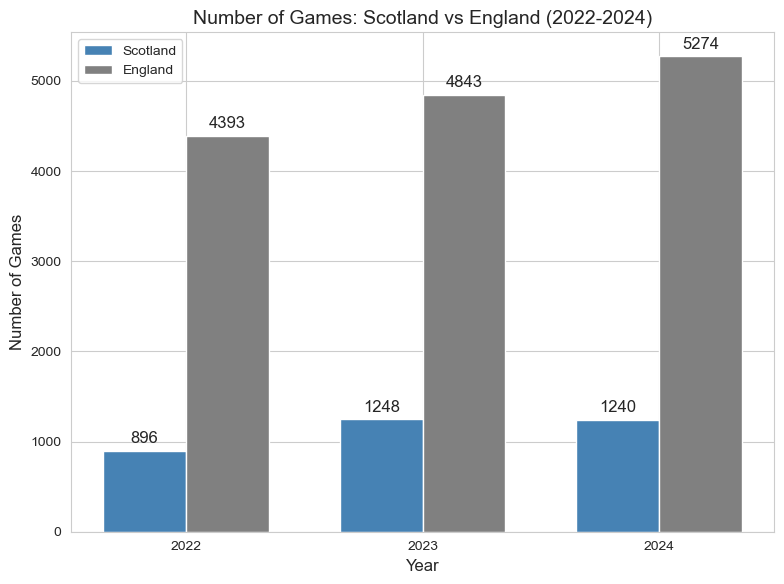

In [45]:
# Data
years = ['2022', '2023', '2024']
scotland_games = [896, 1248, 1240]
england_games = [4393, 4843, 5274]

# Set up the figure and axis
plt.figure(figsize=(8, 6))

# Set the positions of the bars
x = np.arange(len(years))
width = 0.35  # width of the bars

# Create bars
plt.bar(x - width/2, scotland_games, width, label='Scotland', color='steelblue')
plt.bar(x + width/2, england_games, width, label='England', color='grey')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.title('Number of Games: Scotland vs England (2022-2024)')
plt.xticks(x, years)
plt.legend()

# Add value labels on top of each bar
for i in range(len(years)):
    plt.text(i - width/2, scotland_games[i] + 50, f'{scotland_games[i]}', 
             ha='center', va='bottom')
    plt.text(i + width/2, england_games[i] + 50, f'{england_games[i]}', 
             ha='center', va='bottom')

# Adjust layout and display
plt.tight_layout()
plt.show()

## 3. Event Density Analysis

Next, we analyze the trends in yellow cards, corners, and fouls over the years to understand if the increase in event density contributes to the rise in mistakes.


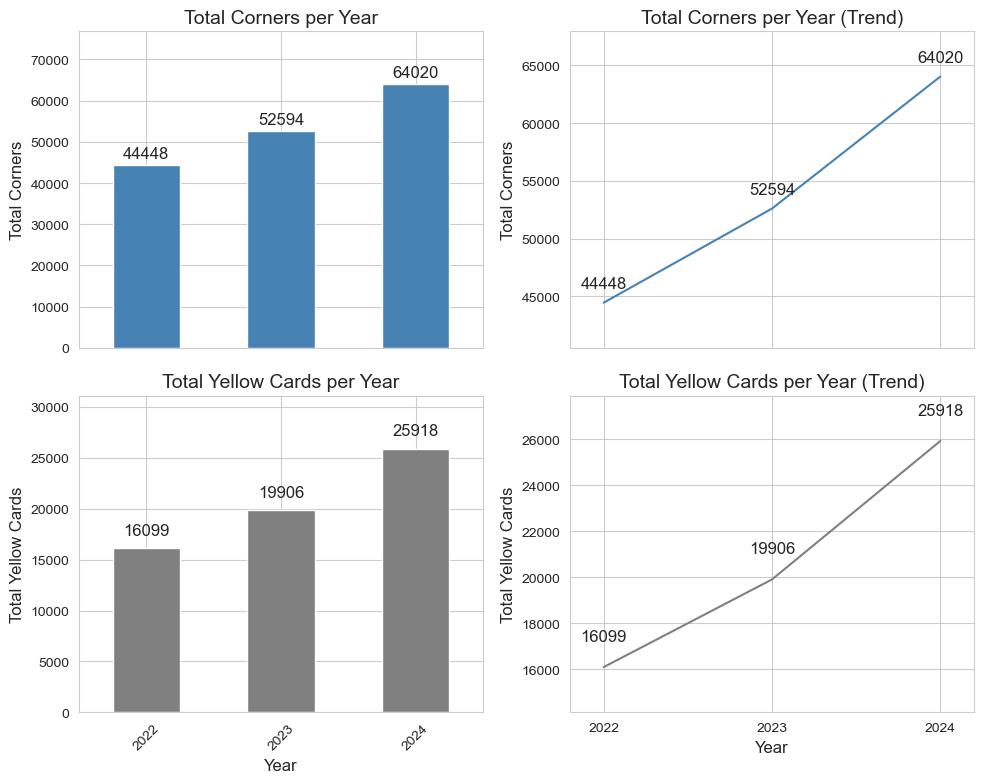


Total Corners per Year:
Year
2022    44448.0
2023    52594.0
2024    64020.0
Name: corner, dtype: float64
Corners Increase (2022-2024): 44.0%

Total Yellow Cards per Year:
Year
2022    16099.0
2023    19906.0
2024    25918.0
Name: yellow card, dtype: float64
Yellow Cards Increase (2022-2024): 61.0%


In [46]:
import matplotlib.pyplot as plt

# Calculate total Corners, Yellow Cards, and Fouls per year
corners_per_year = df_corners_yc.groupby('Year')['corner'].sum()
yc_per_year = df_corners_yc.groupby('Year')['yellow card'].sum()
fouls_per_year = df.groupby('Year')['foul '].sum()

# Ensure the index (Year) is integer for consistency
corners_per_year.index = corners_per_year.index.astype(int)
yc_per_year.index = yc_per_year.index.astype(int)
fouls_per_year.index = fouls_per_year.index.astype(int)

# Create a 2x2 subplot grid with reduced size
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex='col')

# Bar Plot for Corners
corners_per_year.plot(kind='bar', color='steelblue', ax=axs[0, 0])
axs[0, 0].set_title('Total Corners per Year')
axs[0, 0].set_ylabel('Total Corners')
axs[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(corners_per_year):
    axs[0, 0].text(i, v + 1000, f'{int(v)}', ha='center', va='bottom')
axs[0, 0].margins(y=0.2)  # Add 20% margin above the top

# Bar Plot for Yellow Cards
yc_per_year.plot(kind='bar', color='grey', ax=axs[1, 0])
axs[1, 0].set_title('Total Yellow Cards per Year')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Total Yellow Cards')
axs[1, 0].tick_params(axis='x', rotation=45)
axs[1, 0].set_xticklabels([int(x) for x in yc_per_year.index])
for i, v in enumerate(yc_per_year):
    axs[1, 0].text(i, v + 1000, f'{int(v)}', ha='center', va='bottom')
axs[1, 0].margins(y=0.2)  # Add 20% margin above the top

# Line Plot for Corners (no points)
corners_per_year.plot(kind='line', color='steelblue', marker=None, ax=axs[0, 1])
axs[0, 1].set_title('Total Corners per Year (Trend)')
axs[0, 1].set_ylabel('Total Corners')
axs[0, 1].grid(True)
for x, y in zip(corners_per_year.index, corners_per_year):
    axs[0, 1].text(x, y + 1000, f'{int(y)}', ha='center', va='bottom')
axs[0, 1].margins(y=0.2,x=0.1)  # Add 20% margin above the top

# Line Plot for Yellow Cards 
yc_per_year.plot(kind='line', color='grey', marker=None, ax=axs[1, 1])
axs[1, 1].set_title('Total Yellow Cards per Year (Trend)')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Total Yellow Cards')
axs[1, 1].grid(True)
axs[1, 1].set_xticks(yc_per_year.index)
axs[1, 1].set_xticklabels([int(x) for x in yc_per_year.index])
for x, y in zip(yc_per_year.index, yc_per_year):
    axs[1, 1].text(x, y + 1000, f'{int(y)}', ha='center', va='bottom')
axs[1, 1].margins(y=0.2, x=0.1)  # Add 20% margin above the top

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('event_density_trends.png')
plt.show()

# Print totals and calculate increases
print("\nTotal Corners per Year:")
print(corners_per_year)
corners_increase = ((corners_per_year[2024] - corners_per_year[2022]) / corners_per_year[2022]) * 100
print(f"Corners Increase (2022-2024): {corners_increase:.1f}%")

print("\nTotal Yellow Cards per Year:")
print(yc_per_year)
yc_increase = ((yc_per_year[2024] - yc_per_year[2022]) / yc_per_year[2022]) * 100
print(f"Yellow Cards Increase (2022-2024): {yc_increase:.1f}%")

### Interpretation: Event Density Trends

- **Corners Trend**:
  - **Observation**: The bar and line plots show a steady increase in total corners from 2022 to 2024, with a 44% rise (from 44,448 to 64020,).
  - **Impact on Mistakes**: This increase in corners indicates a higher frequency of set-piece events, which are often fast-paced and require quick reporting. The added event density likely contributes to the  mistakes related to corners, as statisticians struggle to keep up with the pace.
  - **Possible Causes**: Changes in attacking styles, such as more wing play or aggressive pressing, may lead to more corners, increasing the workload for statisticians.

- **Yellow Cards Trend**:
  - **Observation**: Yellow cards increased by 61% (from 16,099 to 25,918) over the same period, as shown in the bar and line plots.
  - **Impact on Mistakes**: The significant rise in yellow cards directly correlates with the higher frequency of Yellow Card mistakes (61% of total mistakes). Disciplinary events are often rapid and subjective, making them prone to errors like delays or mixed teams.
  - **Possible Causes**: Stricter officiating or changes in player behavior (e.g., more tactical fouls) could explain the increase, adding pressure on statisticians to report accurately in real-time.




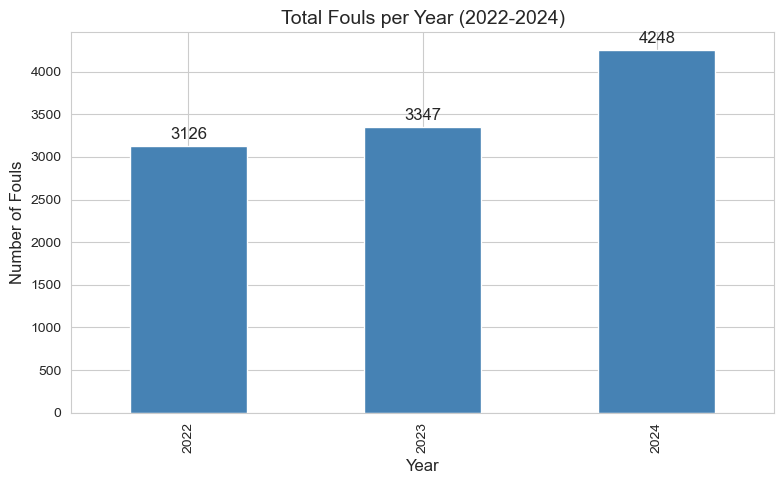


Total Fouls per Year:
Year
2022    3126.0
2023    3347.0
2024    4248.0
Name: foul , dtype: float64
Fouls Increase (2022-2024): 35.9%


In [47]:
# Bar Plot for Fouls per Year
plt.figure(figsize=(8, 5))
fouls_per_year.plot(kind='bar', color='steelblue')
plt.title('Total Fouls per Year (2022-2024)')
plt.xlabel('Year')
plt.ylabel('Number of Fouls')
plt.grid(True)
for i, v in enumerate(fouls_per_year):
    plt.text(i, v + 50, f'{int(v)}', ha='center', va='bottom')
plt.tight_layout()
plt.savefig('fouls_per_year.png')
plt.show()

print("\nTotal Fouls per Year:")
print(fouls_per_year)
fouls_increase = ((fouls_per_year[2024] - fouls_per_year[2022]) / fouls_per_year[2022]) * 100
print(f"Fouls Increase (2022-2024): {fouls_increase:.1f}%")


- **Fouls Trend**:
  - **Observation**: The bar plot indicates a 35.9% increase in fouls (from 3,126 in 2022 to 4,248 in 2024).
  - **Impact on Mistakes**: While fouls are not directly analyzed for mistakes in this study, their increase contributes to overall match intensity, which may indirectly affect the accuracy of reporting other events like yellow cards (often linked to fouls).
  - **Possible Causes**: Similar to yellow cards, stricter officiating or more physical play could be driving the rise in fouls, adding to the complexity of matches.

- **Overall Insight**: The rising event density across corners, yellow cards, and fouls suggests that matches are becoming more action-packed, increasing the cognitive load on statisticians and contributing to the overall 25.4% increase in mistakes.

## 4. Match Complexity Analysis

We investigate how match intensity (measured by `TotalActions`, which includes goals, yellow cards, red cards, penalties, corners, and fouls) contributes to errors, focusing on the relationship between mistake types and match complexity.


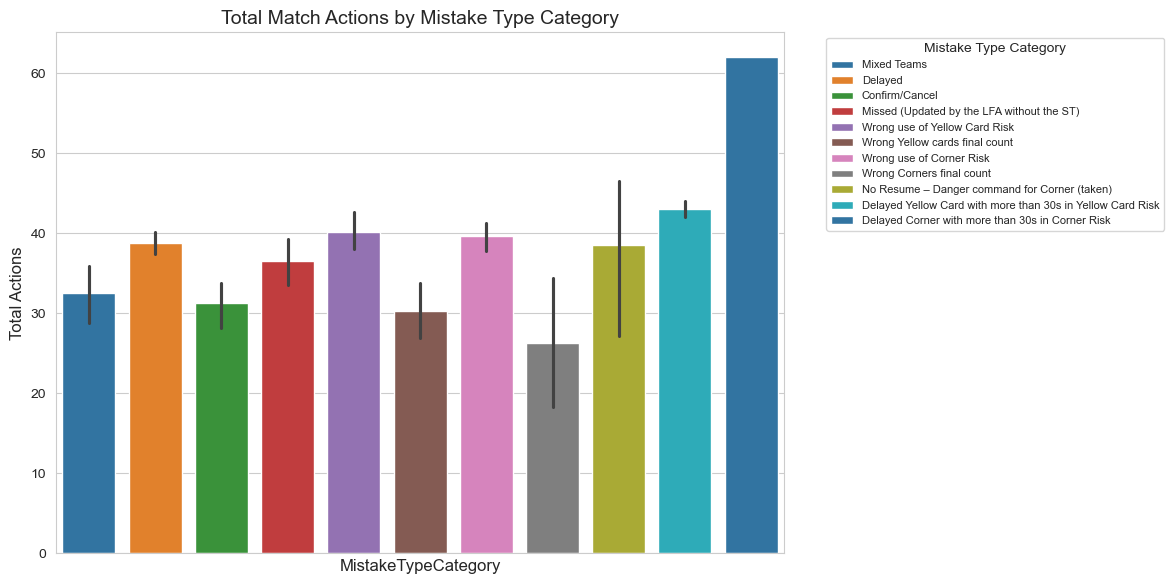

In [48]:
# Create the bar plot for TotalActions by MistakeTypeCategory
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='MistakeTypeCategory', y='TotalActions', hue='MistakeTypeCategory', palette='tab10', legend='brief')
plt.title('Total Match Actions by Mistake Type Category')
plt.ylabel('Total Actions')
plt.xticks([])
plt.grid(True)
plt.legend(title='Mistake Type Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, title_fontsize=10, ncol=1)
plt.tight_layout()
plt.savefig('match_complexity_by_mistake_type_category.png', bbox_inches='tight')
plt.show()



### Interpretation: Match Complexity Analysis

- **Total Actions by Mistake Type Category**:
  - **Observation**: The bar plot shows that matches with mistakes categorized as 'Delayed Yellow Card with more than 30s in Yellow Card Risk' and 'Wrong use of Corner Risk' have the highest average `TotalActions` (around 50–60 actions per match), while 'Mixed Teams' errors occur in matches with slightly lower intensity (around 35 actions).
  - **Impact on Mistakes**: High-intensity matches (with more actions) are more error-prone, particularly for complex events like yellow cards and corners. The rapid pace and volume of actions likely overwhelm statisticians, leading to errors such as delays or incorrect confirmations.
  - **Specific Insights**: Delayed errors (e.g., 'Delayed Yellow Card >30s') in high-action matches suggest that statisticians struggle to process events quickly enough, while 'Wrong use of Corner Risk' errors indicate potential misjudgments in high-pressure situations.




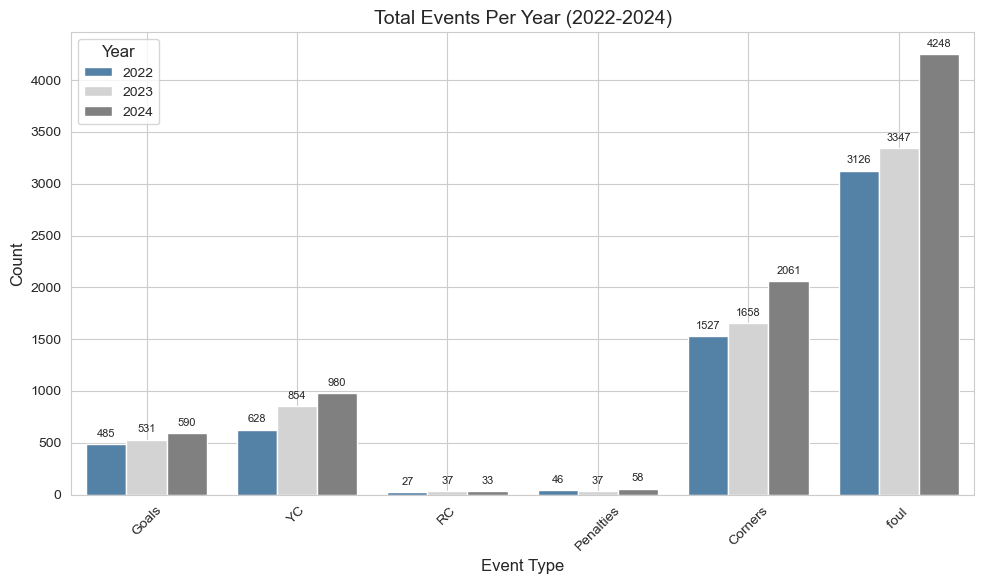

In [49]:
# Grouped bar plot for all events per year
event_types = ['Goals', 'YC', 'RC', 'Penalties', 'Corners', 'foul ']
events_per_year = df.groupby('Year')[event_types].sum()
events_per_year.index = events_per_year.index.astype(int)
events_per_year = events_per_year.reset_index()
events_melted = events_per_year.melt(id_vars='Year', value_vars=event_types, var_name='Event Type', value_name='Count')

plt.figure(figsize=(10, 6))
sns.barplot(data=events_melted, x='Event Type', y='Count', hue='Year', palette=['steelblue', 'lightgrey', 'grey'])
plt.title('Total Events Per Year (2022-2024)')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:
        plt.gca().text(p.get_x() + p.get_width() / 2, height + 50, f'{int(height)}', ha='center', va='bottom', fontsize=8)
plt.legend(title='Year')
plt.tight_layout()
plt.savefig('events_per_year_grouped.png')
plt.show()


- **Events Per Year (Grouped Bar Plot)**:
  - **Observation**: The grouped bar plot shows that all event types (Goals, YC, RC, Penalties, Corners, Fouls) have increased from 2022 to 2024. Notably, yellow cards (YC) and corners show the most significant rises, consistent with the event density analysis.
  - **Impact on Mistakes**: The increase in all event types contributes to overall match complexity, as `TotalActions` per match rises. This heightened intensity directly correlates with the 25.4% increase in mistakes, as statisticians face more events to report in less time.
  - **Yearly Trends**: The consistent growth across all event types suggests a broader trend of more competitive and action-packed matches, which may be driven by changes in playing styles or officiating standards.

- **Overall Insight**: Match complexity, driven by higher `TotalActions` and increased event frequency, is a significant contributor to the rise in mistakes. High-intensity matches amplify the cognitive load on statisticians, particularly for rapid and subjective events like yellow cards.

## 5. Regional Differences

We compare England and Scotland in terms of match intensity and mistake volume to understand regional contributions to the overall increase in errors.


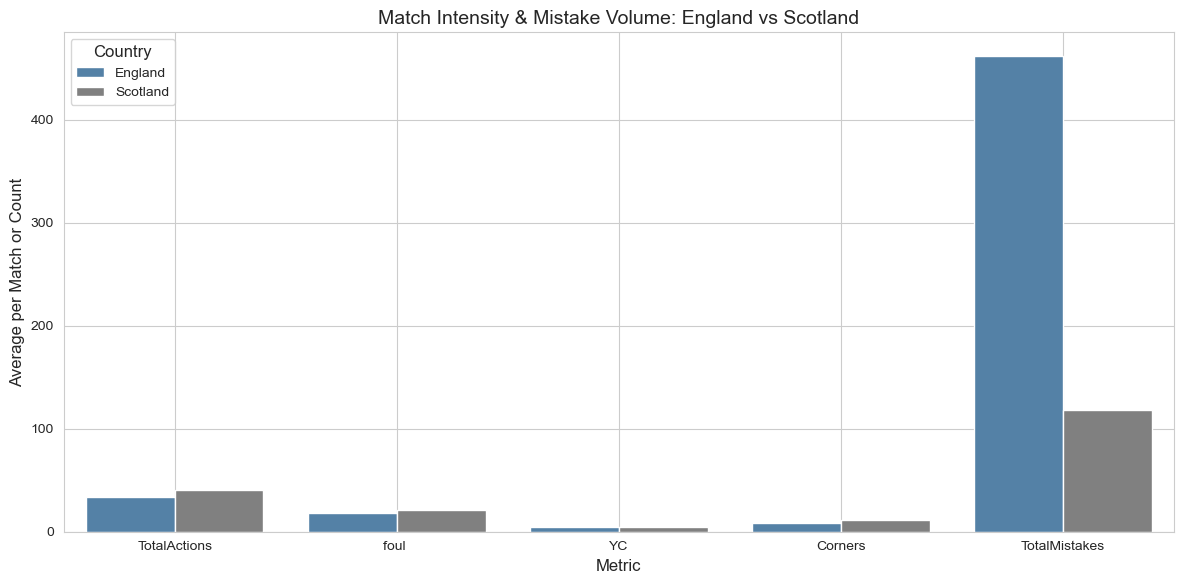

In [11]:
# Regional Comparison
region_stats = df.groupby('Country')[['TotalActions', 'foul ', 'YC', 'Corners']].mean().reset_index()
mistake_counts = df.groupby('Country')['MistakeType'].count().reset_index(name='TotalMistakes')
region_summary = pd.merge(region_stats, mistake_counts, on='Country')

region_melted = region_summary.melt(id_vars='Country', 
                                    value_vars=['TotalActions', 'foul ', 'YC', 'Corners', 'TotalMistakes'],
                                    var_name='Metric', 
                                    value_name='Average')
plt.figure(figsize=(12, 6))
sns.barplot(data=region_melted, x='Metric', y='Average', hue='Country', palette=['steelblue', 'grey'])
plt.title('Match Intensity & Mistake Volume: England vs Scotland')
plt.ylabel('Average per Match or Count')
plt.grid(True)
plt.tight_layout()
plt.savefig('regional_comparison.png')
plt.show()


### Interpretation: Match Intensity & Mistake Volume (England vs Scotland)

- **Match Intensity Comparison**:
  - **Observation**: England has higher averages across all metrics
  - **Implication**: The higher intensity in England, driven by more competitive leagues (e.g., Premier League, Championship), increases the cognitive load on statisticians, making errors more likely.

- **Mistake Volume Comparison**:
  - **Observation**: England accounts for ~80% of total mistakes (464 out of 580), while Scotland accounts for ~20% (116 out of 580).
  - **Implication**: The larger mistake volume in England reflects its significantly higher match volume (4393–5274 games vs. 896–1248 in Scotland). This aligns with the match volume analysis, where England's match volume increased by 19.9% from 2022 to 2024, compared to Scotland's 38.4% (but from a smaller base).

- **Correlation with Mistakes**:
  - The higher `TotalActions` in England suggests that matches are more complex, contributing to the overall 25.4% increase in mistakes. The competitive nature of English leagues likely amplifies event frequency, leading to more opportunities for errors.
  - Scotland, with fewer matches and lower intensity, has fewer mistakes, but the error rate per match (3.55% in 2024) remains above the 2% target, indicating that workload and intensity are issues in both regions.

- **Overall Insight**: England's dominant contribution to the mistake volume underscores the need for targeted interventions in high-volume, high-intensity leagues to reduce errors.


## 6. Mistakes by Competition Analysis

We explore the distribution and trends of mistake types to identify which events are most error-prone and how they have evolved over time.


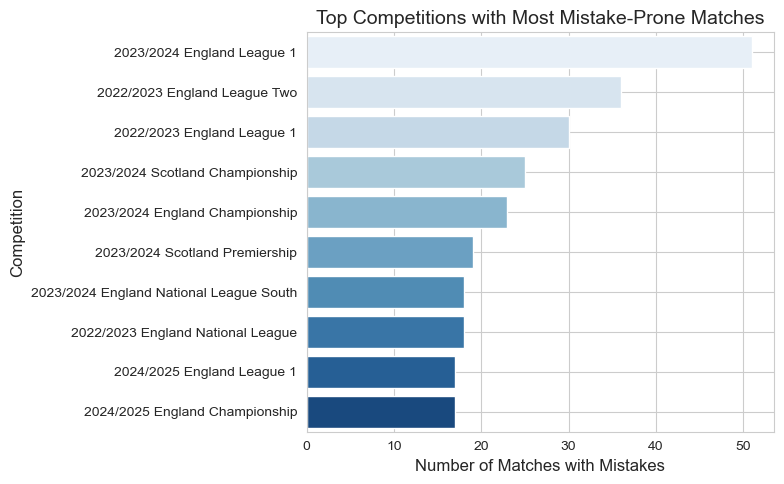

In [10]:

# Mistakes by Competition
comp_mistakes = df['Competition'].value_counts().head(10)
plt.figure(figsize=(8, 5))
sns.barplot(x=comp_mistakes.values, y=comp_mistakes.index, hue=comp_mistakes.index, palette='Blues', legend=False)
plt.title('Top Competitions with Most Mistake-Prone Matches')
plt.xlabel('Number of Matches with Mistakes')
plt.grid(True)
plt.tight_layout()
plt.savefig('mistakes_by_competition.png')
plt.show()


### Interpretation:

- **Top Competitions with Mistakes**:
  - **Observation**: The bar plot shows that the England League One (2023/2024 season) have the highest number of mistake-prone matches, with 85 matches.
  - **Implication**: These competitions, part of England's high-volume leagues, contribute significantly to the overall mistake volume. The competitive nature and high match volume in these leagues likely exacerbate the challenges faced by statisticians.
 
- **Overall Insight**: Yellow Card and corners mistakes are the most significant contributor to the error rate, driven by their rapid occurrence and the increased frequency of disciplinary events. High-volume competitions in England are key areas of concern.


## 7. Conclusion and Recommendations

### Summary of Findings

Our analysis reveals that the 25.4% increase in moderate event errors since 2022 is driven by multiple interconnected factors:

- **Increased Match Volume**: A 25.4% rise in mistake-prone matches (from 173 to 217) directly correlates with the overall increase in mistakes, placing significant pressure on statisticians.
- **Rising Event Density**: Yellow cards increased by 61%, corners by 44%, and fouls by 35.9%, leading to more action-packed matches that heighten the cognitive load on statisticians.
- **Match Complexity**: Matches with higher `TotalActions` (especially those with delayed yellow card errors) are more error-prone, as the rapid pace of events overwhelms statisticians.
- **Regional Differences**: England accounts for 80% of mistakes due to its larger match volume (4393–5274 games) and higher match intensity.
- **Mistake Type Trends**: Yellow Card mistakes dominate (57.6% of total errors), driven by their rapid occurrence and the 61% increase in yellow cards, while high-volume English leagues like the Championship contribute significantly to the error rate.

### Recommendations

To reduce the moderate event error rate below the target of 2%, we propose the following:

1. **Increase Resources**:
   - Assign more statisticians to high-volume leagues, particularly in England (e.g., Championship, League One), to manage the increased match volume and intensity.
   - Implement workload balancing by prioritizing experienced statisticians for high-stakes matches.

2. **Implement Automated Tools**:
   - Use real-time event flagging systems or AI-assisted tracking to reduce the cognitive load on statisticians, especially for rapid events like yellow cards.
   - Automate initial event detection for corners and fouls to minimize delays and missed events.

3. **Enhance Training and Support**:
   - Provide targeted training on handling high-intensity matches, focusing on rapid disciplinary events (e.g., yellow cards) and common error types (e.g., delays, mixed teams).
   - Develop simulation-based training to improve decision-making under pressure.

4. **Standardize Reporting Protocols**:
   - Establish clear guidelines for reporting yellow cards and corners, including mandatory double-checks for subjective events.
   - Use standardized criteria for confirming or canceling events to reduce errors like mixed teams or incorrect confirmations.

By addressing these workload, complexity, and procedural challenges, the reliability of football statistics can be significantly improved, benefiting coaches, analysts, and stakeholders.
